In [2]:
import pandas as pd
import numpy as np

In [3]:
import json

In [4]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [5]:
import re
import csv

In [6]:
import matplotlib.pyplot as plt 

In [7]:
import nltk

In [8]:
import seaborn as sns
from tqdm import tqdm

In [9]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [10]:
meta = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)


In [11]:
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [12]:
plots = []

with open('plot_summaries.csv', encoding="utf8",newline='') as csvfile:
    plots = list(csv.reader(csvfile))


In [13]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in plots:
    movie_id.append(i[0])
    plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

In [14]:
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')


In [15]:
json.loads(movies['genre'][0]).values()

dict_values(['Action/Adventure', 'Science Fiction', 'Action', 'Drama'])

In [16]:
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [17]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [18]:
all_genres = sum(genres,[])
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

[Text(0,0.5,'Count')]

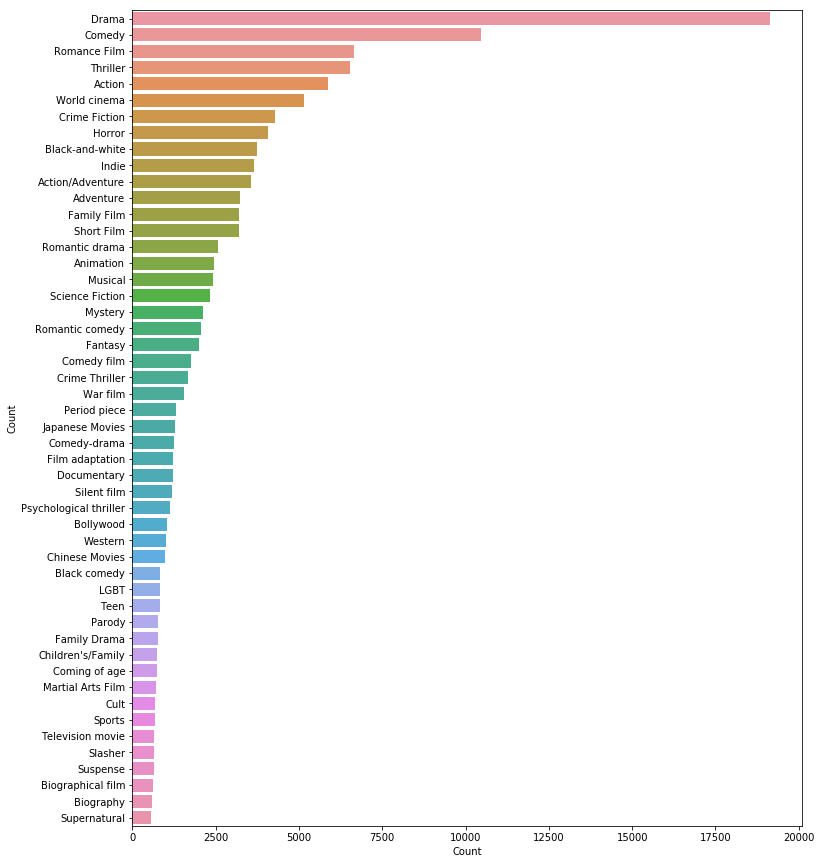

In [19]:

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 


In [20]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [21]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

C:\Users\adity\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


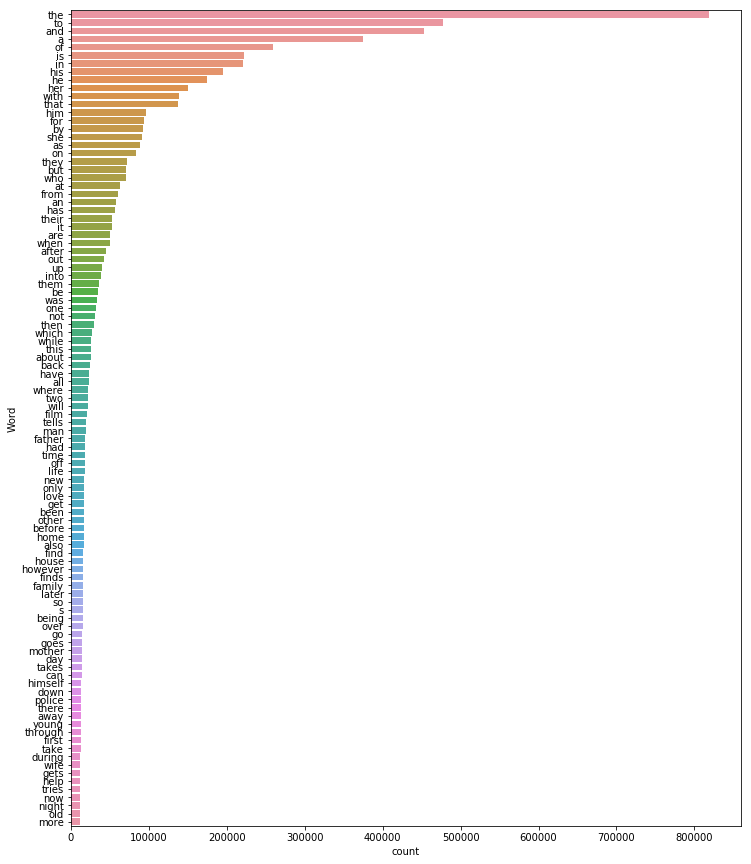

In [22]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

C:\Users\adity\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


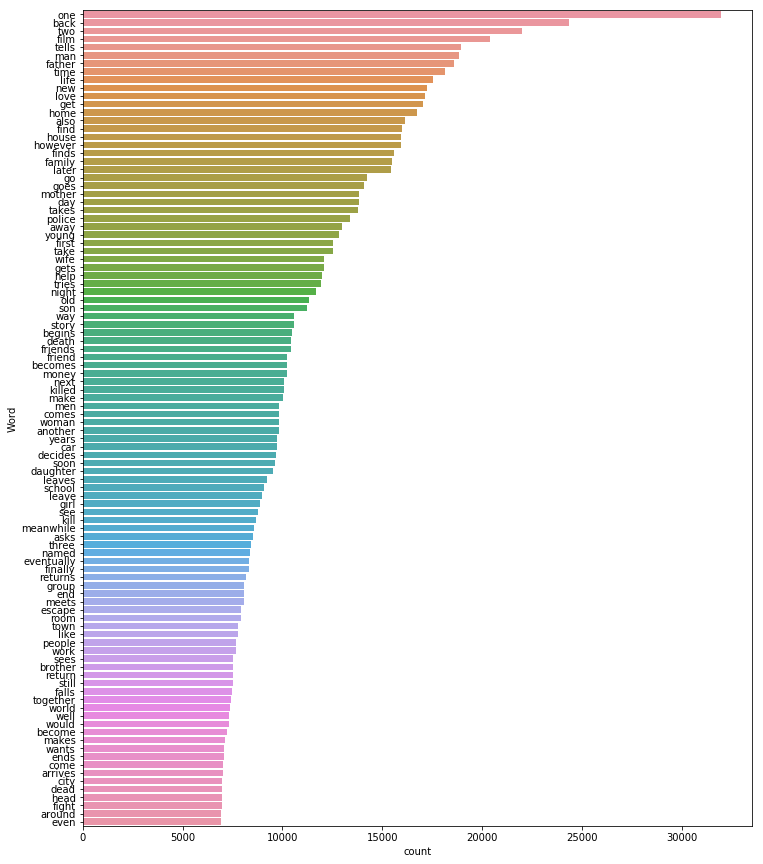

In [24]:
freq_words(movies_new['clean_plot'], 100)


In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)


In [30]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [31]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
print(xtrain_tfidf.shape)

(33433, 10000)


In [38]:
print
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score
print(xval.shape)

(8359,)


In [39]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [40]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
C:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [33]:
y_pred = clf.predict(xval_tfidf)

In [35]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Drama',)

In [157]:
f1_score(yval, y_pred, average="micro")
def Nmaxelements(list1, N,q): 
    
  
    for i in range(0, N):  
        max1 = 0
          
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j]; 
                  
        list1.remove(max1); 
        q.append(max1) 
          
    #print(final_list) 

In [86]:
y_pred_prob = clf.predict_proba(xval_tfidf)
print(xval_tfidf.shape)
#print((y_pred_prob[1]))
q=[]
Nmaxelements(y_pred_prob[1].tolist(), 3,q) 
print(q)
l=[]
for j in range(0,363):
    if(y_pred_prob[1][j]==q[0] or y_pred_prob[1][j]==q[1] or y_pred_prob[1][j]==q[2]):
        l.append(1)
    else:
        l.append(0)
l=np.asarray(l)
print(l.shape)
l=l.reshape(1,363)
print(multilabel_binarizer.inverse_transform(l))

#print(y_pred_prob[1][114])

(8359, 10000)
[]
[0.6012227139738707, 0.5500132387939994, 0.24967668758438352]
(363,)
[('Comedy', 'Family Film', 'Fantasy')]


In [38]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)
print(y_pred_new)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
f1_score(yval, y_pred_new, average="micro")

0.4397826309853378

In [40]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [193]:
for i in range(40000): 
  k = xval.index[i] 
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")

Movie:  Blue Blazes 
Predicted genre:  [()]
Actual genre:  ['Short Film', 'Comedy', 'Black-and-white'] 

Movie:  The Happy Elf 
Predicted genre:  [('Comedy', 'Family Film')]
Actual genre:  ["Children's/Family", 'Computer Animation', 'Holiday Film', 'Animation', 'Musical', "Children's", "Children's Fantasy", 'Music', 'Family Film'] 

Movie:  In a Dark Place 
Predicted genre:  [('Drama',)]
Actual genre:  ['Thriller', 'Horror', 'Psychological thriller', 'Supernatural'] 

Movie:  Amudhey 
Predicted genre:  [('Drama',)]
Actual genre:  ['Romance Film', 'Action'] 

Movie:  Final Reprisal 
Predicted genre:  [('Action',)]
Actual genre:  ['Action', 'War film'] 

Movie:  Ice Queen 
Predicted genre:  [('Horror', 'Thriller')]
Actual genre:  ['Monster movie', 'B-movie', 'Horror'] 

Movie:  A Ton of Luck 
Predicted genre:  [('Drama',)]
Actual genre:  ['Action/Adventure', 'Crime Comedy', 'Comedy-drama', 'Comedy', 'World cinema'] 

Movie:  Vel 
Predicted genre:  [('Drama',)]
Actual genre:  ['Romance Fi

Predicted genre:  [('Comedy', 'Drama', 'Romance Film')]
Actual genre:  ['Ensemble Film', 'Female buddy film', 'Comedy-drama', 'Drama', 'Comedy', 'Romantic drama', 'Romance Film'] 

Movie:  Persuasion 
Predicted genre:  [('Drama', 'Romance Film')]
Actual genre:  ['Costume drama', 'Romance Film', 'Drama', 'Period piece', 'Romantic drama'] 

Movie:  September Dawn 
Predicted genre:  [('Drama',)]
Actual genre:  ['Western', 'Action/Adventure', 'Revisionist Western', 'Period piece', 'Drama', 'Romantic drama', 'Romance Film'] 

Movie:  Kickboxer 
Predicted genre:  [()]
Actual genre:  ['Action/Adventure', 'Thriller', 'Action', 'Martial Arts Film'] 

Movie:  The Lives of Others 
Predicted genre:  [('Drama', 'Thriller', 'World cinema')]
Actual genre:  ['Thriller', 'World cinema', 'Period piece', 'Drama', 'Political thriller', 'Political drama'] 

Movie:  Merupu Daadi 
Predicted genre:  [('Action',)]
Actual genre:  ['Western', 'Action', 'Drama'] 

Movie:  Afterburn 
Predicted genre:  [('Drama',)]

KeyboardInterrupt: 

In [105]:
q=xval[xval.index[3] ]
print(movies_new['movie_name'][xval.index[3]])

Amudhey


In [106]:
q = clean_text(q)
q = remove_stopwords(q)
q_vec = tfidf_vectorizer.transform([q])
q_pred = clf.predict(q_vec)

In [142]:
multilabel_binarizer.inverse_transform(q_pred)
def src(ac,z):
    for i in(ac):
        print("I",i)
        print("Z",z)
        if(z==i):
            print(z)
    

In [197]:
y_pred_prob = clf.predict_proba(xtrain_tfidf)
w=['Drama','Family Film','Romance Film','Thriller','Comedy','Horror']
fin=[]
movie=[]
for a in range(32000):
    q=xtrain[xtrain.index[a] ]
    movie.append((movies_new['movie_name'][xtrain.index[a]]))
    #print((y_pred_prob[a]))
    q=[]
    Nmaxelements(y_pred_prob[a].tolist(), 3,q) 
    #print(q)
    l=[]
    for j in range(0,363):
        if(y_pred_prob[a][j]==q[0] or y_pred_prob[a][j]==q[1] or y_pred_prob[a][j]==q[2]):
            l.append(1)
        else:
            l.append(0)
    l=np.asarray(l)
    #print(l.shape)
    l=l.reshape(1,363)
    pr=multilabel_binarizer.inverse_transform(l)
    ac=movies_new['genre_new'][xtrain.index[a]]
    pr=np.asarray(pr)
    ac=np.asarray(ac)
    pr=pr.tolist()
    ac=ac.tolist()
    s=0
    for x in range(0,3):
        #print("pr",pr[0][x])
        if(pr[0][x] in ac):
            #print("Predicted : ",pr[0][x])
            fin.append(pr[0][x])
            break
        if(x==2):
            for i in w:
                if(i in ac):
                    fin.append(i)
                    s=1
                    break
            if(s==0):
                fin.append(ac[0])
    

            


    #print(y_pred_prob[1][114])

In [198]:
fin=np.asarray(fin)
print(fin.shape)
fin=np.reshape(fin,(1,32000))
movie=np.asarray(movie)
print(movie.shape)
movie=np.reshape(movie,(1,32000))
print(movie)

(32000,)
(32000,)
[['Unprecedented: The 2000 Presidential Election' 'Dark Souls'
  'Very Annie Mary' ... 'Pirates of the High Seas' 'The Joy Luck Club'
  'Deathtrap']]


In [174]:
fin=np.asarray(fin)
print(fin[0])

8359


In [185]:
import xlsxwriter

In [199]:
workbook = xlsxwriter.Workbook('FinGenre.xlsx')
worksheet = workbook.add_worksheet()

row = 0

for col, data in enumerate(fin):
    worksheet.write_column(row, col, data)

workbook.close()


In [200]:
workbook = xlsxwriter.Workbook('MoviesGenre.xlsx')
worksheet = workbook.add_worksheet()

row = 0

for col, data in enumerate(movie):
    worksheet.write_column(row, col, data)

workbook.close()


In [202]:
movies

,movie_id,plot,movie_name,genre,genre_new
0,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
1,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
2,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
3,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"
4,5272176,"The president is on his way to give a speech. While he is traveling there a man shows up with a camera. A reporter tries to ask a member of the secret service a question. When the president enters he is shot by the man with the camera. The president's main bodyguard, Alex Thomas , is grazed by t...",End Game,"{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Action/Adventure"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Thriller, Action/Adventure, Action, Drama]"
5,1952976,"{{plot}} The film opens in 1974, as a young girl, Dahlia, stands outside after school in the rain, waiting for her mother. Flash forward to 2005, we see a grown-up Dahlia in the midst of a bitter mediation with ex-husband, Kyle , over custody of their daughter, Cecilia . Kyle wants Cecilia to l...",Dark Water,"{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama"", ""/m/03npn"": ""Horror""}","[Thriller, Drama, Horror]"
6,24225279,"The story begins with Hannah, a young Jewish teen, as she is completing her senior year of high school. Her small neighborhood in Brooklyn is falling apart and SING! is one of the only traditions keeping the neighborhood alive. Newly arrived teacher, Miss Lombardo grew up in the neighborhood but...",Sing,"{""/m/07s9rl0"": ""Drama"", ""/m/02b5_l"": ""Teen""}","[Drama, Teen]"
7,2462689,"Infuriated at being told to write one final column after being laid off from her newspaper job, Ann Mitchell prints a letter from a fictional unemployed ""John Doe"" threatening suicide on Christmas Eve in protest of society's ills. When the note causes a sensation and the paper's competition sus...",Meet John Doe,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3nby"": ""Media Satire"", ""/m/09n5t_"": ""Americana"", ""/m/01t_vv"": ""Comedy-drama"", ""/m/01g6gs"": ""Black-and-white"", ""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy"", ""/m/02l7c8"": ""Romance Film""}","[Romantic comedy, Media Satire, Americana, Comedy-drama, Black-and-white, Drama, Comedy, 

In [44]:
first_vector_tfidfvectorizer=xtrain_tfidf[0]
print(xtrain[0])

nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older sister katniss volunteers take place peeta mellark bakers son gave katniss bread starving district tribute katniss peeta taken capitol accompanied frequently drunk mentor past victor haymitch abernathy warns career tributes train intensively special academies almost always win tv interview caesar flickerman peeta unexpectedly reveals love katniss outraged believing ploy gain audience support sponsors may provide games gifts food medicine tools however discovers peeta meant said televised games begin half tributes killed first minutes katniss barely survives ignoring haymitchs advice run away melee tempting supplies weapons strewn front structure called cornucopia peeta forms uneasy alliance four care

In [42]:
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
vote,0.344961
data,0.255512
film,0.204760
system,0.190943
votes,0.189936
republican,0.188409
democratic,0.188040
katherine,0.183361
many,0.176149
harris,0.168537
